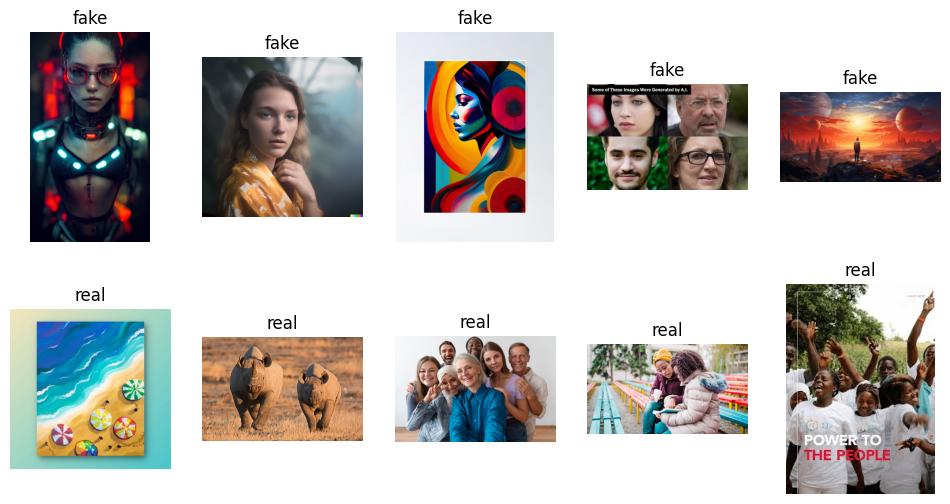

In [58]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Define dataset path
dataset_path = "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test"  # Update with your dataset path

# List categories (fake & real)
categories = [category for category in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, category))]

# Load sample images (filter out directories)
sample_images = []
for category in categories:
    class_path = os.path.join(dataset_path, category)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
    for img in images[:5]:  # Limit to first 5 images per category
        img_path = os.path.join(class_path, img)
        sample_images.append((img_path, category))

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (img_path, label) in enumerate(sample_images):
    img = load_img(img_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.show()


In [59]:
IMG_SIZE = (128, 128)  # Resize images
BATCH_SIZE = 32

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)  # Resize
    img_array = img_to_array(img) / 255.0  # Normalize
    return img_array

# Load all images and labels
image_data = []
labels = []
label_map = {category: idx for idx, category in enumerate(categories)}

for category in categories:
    class_path = os.path.join(dataset_path, category)
    images = os.listdir(class_path)
    for img in images:
        img_path = os.path.join(class_path, img)
        image_data.append(load_and_preprocess_image(img_path))
        labels.append(label_map[category])

# Convert to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (359, 128, 128, 3), Validation shape: (40, 128, 128, 3), Test shape: (100, 128, 128, 3)


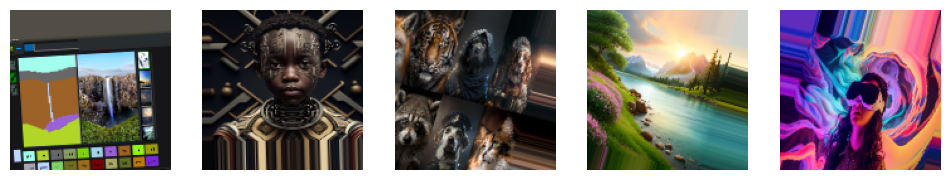

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented images
augmented_images = datagen.flow(X_train[:5], batch_size=5)

# Display augmented images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, img in enumerate(augmented_images):  # Only one batch of 5 images
    if i >= 1:  # Only process the first batch
        break
    for j in range(5):  # Loop through the 5 images in the batch
        axes[j].imshow(img[j])  # img[j] is the individual image in the batch
        axes[j].axis("off")
plt.show()


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")  # Number of categories
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 616ms/step - accuracy: 0.6954 - loss: 0.6968 - val_accuracy: 0.8000 - val_loss: 0.5390
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 676ms/step - accuracy: 0.7898 - loss: 0.5307 - val_accuracy: 0.8000 - val_loss: 0.4796
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 590ms/step - accuracy: 0.7652 - loss: 0.5692 - val_accuracy: 0.8000 - val_loss: 0.5603
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - accuracy: 0.7707 - loss: 0.5537 - val_accuracy: 0.8000 - val_loss: 0.4562
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 593ms/step - accuracy: 0.7966 - loss: 0.4585 - val_accuracy: 0.8000 - val_loss: 0.4665
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 650ms/step - accuracy: 0.7501 - loss: 0.5116 - val_accuracy: 0.8000 - val_loss: 0.4824
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 605ms/step - accuracy: 0.7819 - loss: 0.4658 - val_accuracy: 0.8000 - val_loss: 0.5112
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 569ms/step - accuracy: 0.8037 - loss: 0.4427 - val_accuracy: 

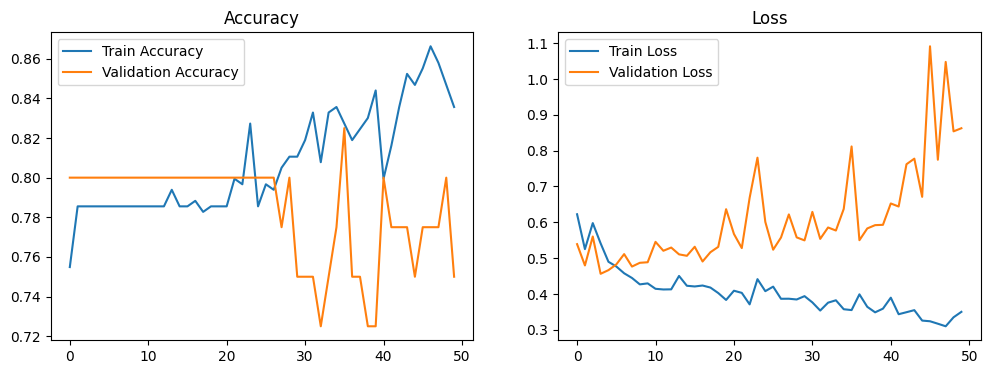

In [63]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [64]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7170 - loss: 0.7289
Test Accuracy: 0.7300


In [65]:
# Save the trained model
model.save('/kaggle/working/fake_image_model.h5')


In [66]:
# Load and preprocess your image (adjust path and image size as necessary)
input_img = image.load_img('/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test/fake/123.jpg', target_size=(128, 128))  # Adjust to your image path
input_array = image.img_to_array(input_img)
input_array = np.expand_dims(input_array, axis=0)  # Add batch dimension

# Normalize image to match the input used for training (if required)
input_array = input_array / 255.0  # Assuming model was trained with normalized images

# Get predictions from the model
predictions = model(input_array)

# Print the raw output (prediction probabilities for each class)
print("Raw predictions (probabilities for each class):", predictions)

# If it's a classification task, get the class with the highest probability
predicted_class_idx = np.argmax(predictions, axis=-1)  # Get index of max probability
print(f"Predicted class index: {predicted_class_idx}")

# If you have class labels, you can map this index back to a class name
class_labels = ['fake', 'real']  
predicted_class_name = class_labels[predicted_class_idx[0]]  # For single image
print(f"Predicted class name: {predicted_class_name}")

# Optionally, if you have true labels, you can also print accuracy and compare
# true_label = ...  # Load true label for comparison
# accuracy = np.mean(predicted_class_idx == true_label)
# print(f"Accuracy: {accuracy * 100:.2f}%")


Raw predictions (probabilities for each class): tf.Tensor([[0.8968365  0.10316349]], shape=(1, 2), dtype=float32)
Predicted class index: [0]
Predicted class name: fake
